# Customer Segmentation Case Study

## Introduction

This case study explores customer segmentation using data mining techniques on mall customer data. The analysis applies clustering, dimensionality reduction, and association rule mining to identify meaningful customer segments and patterns that can inform targeted marketing strategies.

**Data Source:** Mall Customer Segmentation Data  : https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python


### Description
The dataset contains the following attributes for each customer:

- **CustomerID**: Unique identifier for each customer
- **Gender**: Customer's gender (Male/Female)
- **Age**: Customer's age in years
- **Annual Income (k$)**: Annual income in thousands of dollars
- **Spending Score (1-100)**: Mall-defined score based on customer behavior and spending nature


## Business Objectives

This analysis aims to answer the following key business questions:

1. **Customer Segmentation**: What are the distinct customer segments in our mall?
2. **Pattern Discovery**: What patterns exist between customer demographics and spending behavior?
3. **Marketing Application**: How can we use these insights for targeted marketing campaigns?

## Analytical Approach

The study will employ three core data mining techniques:

- **Clustering**: Group customers into meaningful segments based on similarities
- **Dimensionality Reduction**: Visualize high-dimensional customer data in 2D/3D space
- **Association Rule Mining**: Discover relationships and patterns in customer attributes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')





# 1. DATA LOADING AND EXPLORATION

In this section, we:
- Import the required Python libraries and load the dataset.
- Initial Exploration revealed to understand the dataset structure, quality, and distributions


In [8]:
# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

#from google.colab import drive
#drive.mount('/content/drive')
#path = "/content/drive/MyDrive/.../Mall_Customers.csv"

#df = df = pd.read_csv(path)
df = pd.read_csv('Mall_Customers.csv')

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(df.head())
print(f"\nShape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
# print(f"\nStatistical Summary:\n{df.describe()}")


DATASET OVERVIEW
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Shape: (200, 5)

Data Types:
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Missing Values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


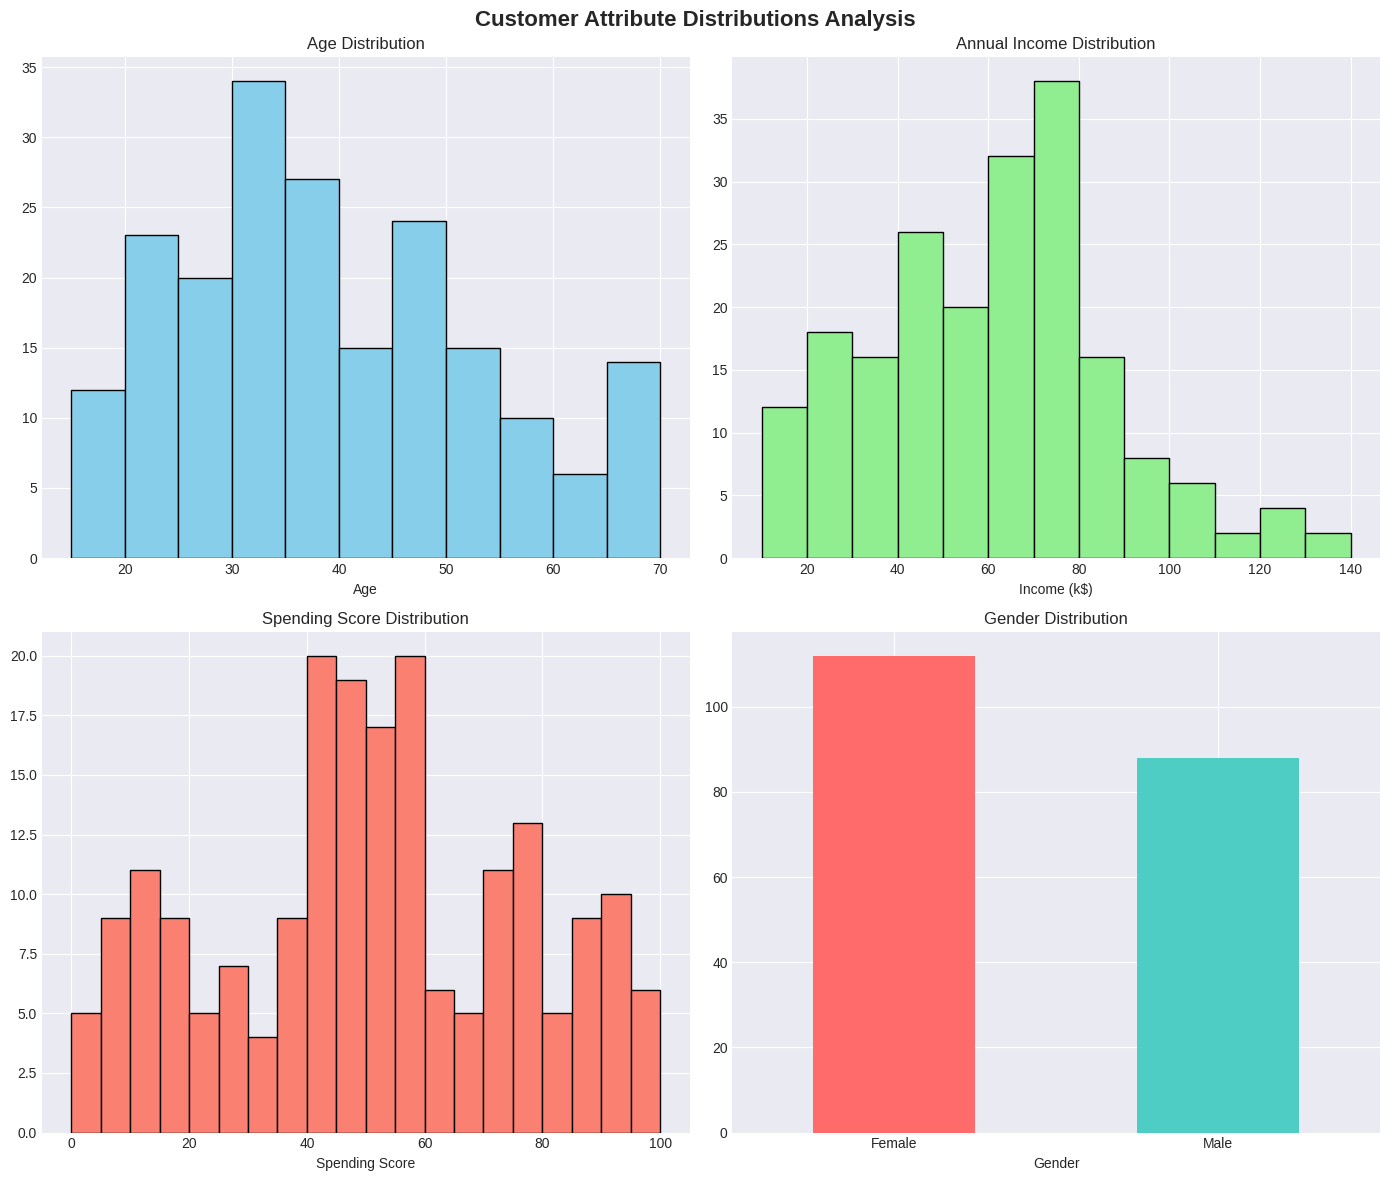

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Age
df['Age'].hist(bins=range(15, 75, 5), ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')

# Income
df['Annual Income (k$)'].hist(bins=range(10, 150, 10), ax=axes[0, 1], color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Annual Income Distribution')
axes[0, 1].set_xlabel('Income (k$)')

# Spending Score
df['Spending Score (1-100)'].hist(bins=range(0, 105, 5), ax=axes[1, 0], color='salmon', edgecolor='black')
axes[1, 0].set_title('Spending Score Distribution')
axes[1, 0].set_xlabel('Spending Score')

# Gender
df['Gender'].value_counts().plot(kind='bar', ax=axes[1, 1], color=['#FF6B6B', '#4ECDC4'])
axes[1, 1].set_title('Gender Distribution')
axes[1, 1].set_xlabel('Gender')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.suptitle('Customer Attribute Distributions Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('01_data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. DATA PREPROCESSING


Step Involved:
- Encoded Gender: Converted 'Male'/'Female' to 0/1 for numerical processing
- Selected Features: Chose Age, Income, and Spending Score as clustering variables
- Standardized Data: Scaled all features to mean=0, std=1





In [ ]:

# Encode gender
df['Gender_Encoded'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Select features for clustering
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features selected:", features)
print("Scaled data shape:", X_scaled.shape)


Features selected: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Scaled data shape: (200, 3)


# 3. CLUSTERING ANALYSIS

Steps Involved
1. **Optimal K Search:** Tested K = 2–10 using the **Elbow** and **Silhouette** methods.  
2. **Model Fitting:** Applied two algorithms — **K-Means** and **Hierarchical Clustering**  




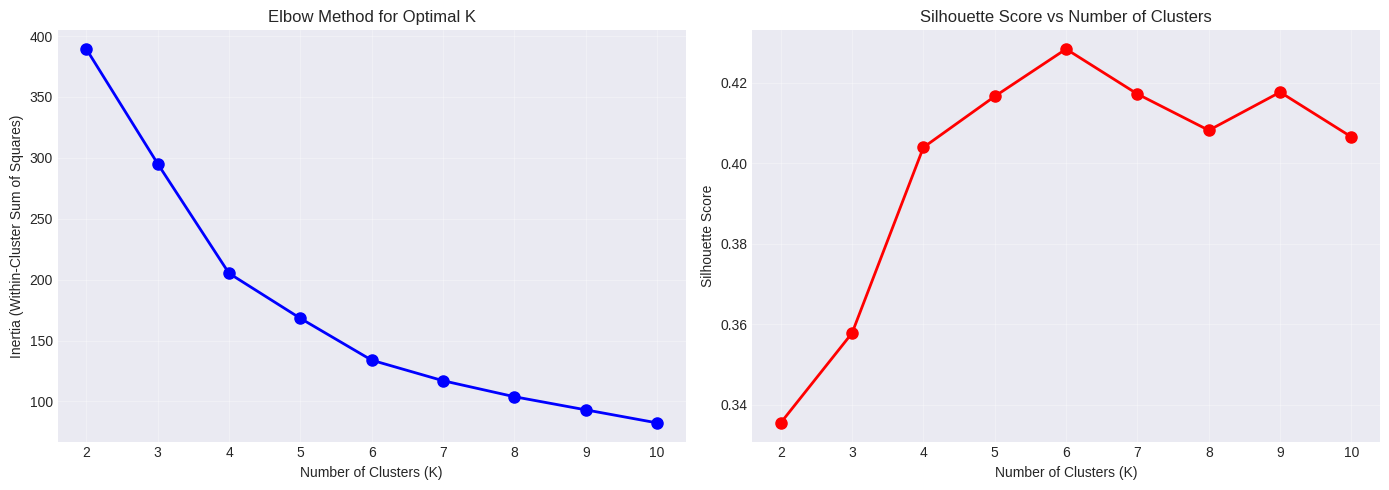

In [ ]:

# Elbow Method for optimal K
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow and Silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)')
axes[0].set_title('Elbow Method for Optimal K')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_optimal_k_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


K-Means Clustering (K=6):
Silhouette Score: 0.428


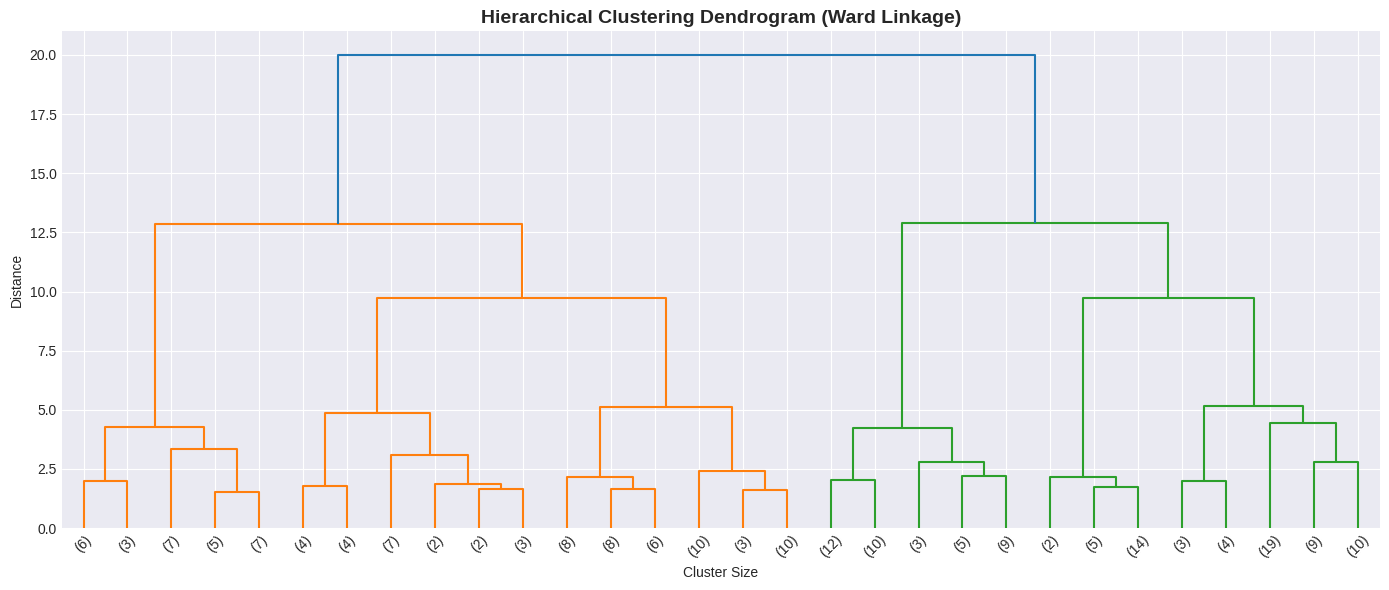


Hierarchical Clustering (K=6):
Silhouette Score: 0.420

CLUSTER PROFILING (K-Means)
                      Age  Annual Income (k$)  Spending Score (1-100)
KMeans_Cluster                                                       
0               56.333333           54.266667               49.066667
1               26.794872           57.102564               48.128205
2               41.939394           88.939394               16.969697
3               32.692308           86.538462               82.128205
4               25.000000           25.260870               77.608696
5               45.523810           26.285714               19.380952

  CLUSTER Analysis:
Cluster 0: Senior Shoppers
  - Avg Income: $54.3k
  - Avg Spending: 49.1/100
  - Avg Age: 56.3
  - Dominant Gender: Female

Cluster 1: Middle Class Moderates
  - Avg Income: $57.1k
  - Avg Spending: 48.1/100
  - Avg Age: 26.8
  - Dominant Gender: Female

Cluster 2: Wealthy Conservatives
  - Avg Income: $88.9k
  - Avg Spending: 17.0/

In [ ]:
# 1. K-Means Clustering (using k=6 as optimal)
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nK-Means Clustering (K={optimal_k}):")
print(f"Silhouette Score: {silhouette_score(X_scaled, df['KMeans_Cluster']):.3f}")

# 2. Hierarchical Clustering
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig('03_dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
df['Hierarchical_Cluster'] = hierarchical.fit_predict(X_scaled)

print(f"\nHierarchical Clustering (K={optimal_k}):")
print(f"Silhouette Score: {silhouette_score(X_scaled, df['Hierarchical_Cluster']):.3f}")

# Cluster profiling

print("\n" + "=" * 80)
print("CLUSTER PROFILING (K-Means)")
print("=" * 80)
cluster_summary = df.groupby('KMeans_Cluster')[features].mean()
print(cluster_summary)

# Create meaningful cluster names based on profiling
cluster_counts = df['KMeans_Cluster'].value_counts().sort_index()
cluster_names = {}

for cluster_id in sorted(df['KMeans_Cluster'].unique()):
    cluster_data = df[df['KMeans_Cluster'] == cluster_id]
    avg_income = cluster_data['Annual Income (k$)'].mean()
    avg_spending = cluster_data['Spending Score (1-100)'].mean()
    avg_age = cluster_data['Age'].mean()
    dominant_gender = cluster_data['Gender'].value_counts().index[0]

    # Name clusters based on characteristics
    if avg_income > 70 and avg_spending > 60:
        name = "High Rollers"
    elif avg_income < 40 and avg_spending < 40:
        name = "Budget Shoppers"
    elif avg_age < 35 and avg_spending > 60:
        name = "Young Spenders"
    elif avg_income > 70 and avg_spending < 40:
        name = "Wealthy Conservatives"
    elif avg_age > 45 and avg_spending < 50:
        name = "Senior Shoppers"
    else:
        name = "Middle Class Moderates"

    cluster_names[cluster_id] = {
        'name': name,
        'avg_income': avg_income,
        'avg_spending': avg_spending,
        'avg_age': avg_age,
        'dominant_gender': dominant_gender
    }

print("\n  CLUSTER Analysis:")
for cluster_id, info in cluster_names.items():
    print(f"Cluster {cluster_id}: {info['name']}")
    print(f"  - Avg Income: ${info['avg_income']:.1f}k")
    print(f"  - Avg Spending: {info['avg_spending']:.1f}/100")
    print(f"  - Avg Age: {info['avg_age']:.1f}")
    print(f"  - Dominant Gender: {info['dominant_gender']}\n")

# 4. DIMENSIONALITY REDUCTION - Principle Component Analysis

### Steps Performed
1. **Fit PCA:** Trained PCA on the standardized features (`X_scaled`).
2. **Variance Metrics:** Computed per-component **explained variance ratios** and their **cumulative sum**.
3. **Plots:**
   - **Scree plot** (bars + variance curve) across principal components.
   - **Cumulative variance** curve with a **95% threshold** guideline.
   - **2D PCA projection** (PC1 vs PC2) colored by **K-Means cluster**.

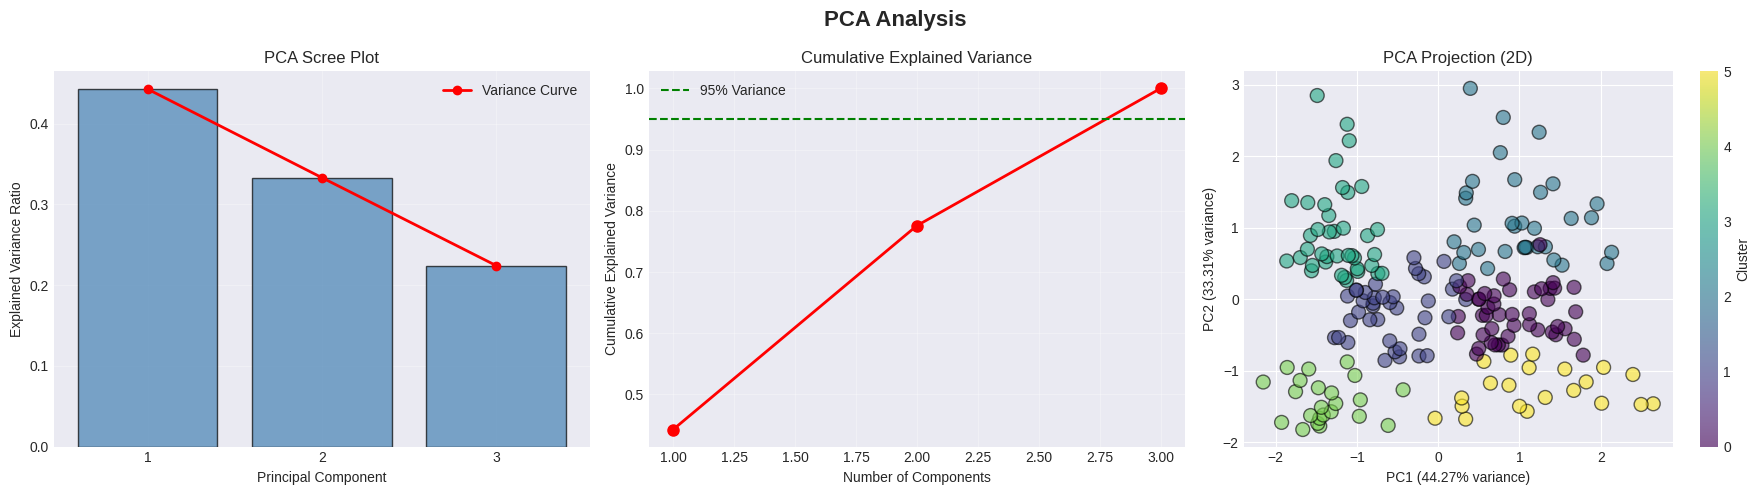



Explained variance by each component: [0.44266167 0.33308378 0.22425454]
Cumulative variance: [0.44266167 0.77574546 1.        ]


In [ ]:
# PCA Analysis
pca = PCA()
pca.fit(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scree plot with bar and line
axes[0].bar(range(1, len(explained_variance) + 1), explained_variance,
            color='steelblue', alpha=0.7, edgecolor='black')
axes[0].plot(range(1, len(explained_variance) + 1), explained_variance,
             'ro-', linewidth=2, markersize=6, label='Variance Curve')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Scree Plot')
axes[0].set_xticks(range(1, len(explained_variance) + 1))
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             'ro-', linewidth=2, markersize=8)
axes[1].axhline(y=0.95, color='green', linestyle='--', label='95% Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 2D PCA Projection
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

scatter_pca = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=df['KMeans_Cluster'],
                              cmap='viridis', s=100, alpha=0.6, edgecolors='black')
axes[2].set_xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
axes[2].set_ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
axes[2].set_title('PCA Projection (2D)')
plt.colorbar(scatter_pca, ax=axes[2], label='Cluster')

plt.suptitle('PCA Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('05_pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n")
print(f"Explained variance by each component: {explained_variance}")
print(f"Cumulative variance: {cumulative_variance}")

# 5. ASSOCIATION RULE MINING

We applied association rule mining to discover patterns in customer attributes.

Since the data contains continuous variables (age, income, spending), we first

discretized them into categorical bins, then used the Apriori algorithm to find

frequent itemsets and generate association rules.
### Steps Involved
1. **Feature Binning:** Discretized continuous fields into categories  
   - `Age → Age_Group` (18–25, 26–35, …)  
   - `Annual Income (k$) → Income_Level` (Low, Medium, High, Very High)  
   - `Spending Score → Spending_Level` (Low/Medium/High)

2. **Transaction Building:** For each customer, created a basket of items:  
   `Gender_*`, `Age_*`, `Income_*`, `Spending_*`, and `Cluster_*` (from K-Means).

3. **One-Hot Encoding:** Used **TransactionEncoder** to convert baskets into a transaction matrix.

4. **Frequent Itemsets (Apriori):** Ran **apriori** with `min_support = 0.10`; annotated itemset lengths.

5. **Rule Generation:** Computed association rules with metric **lift** (`min_threshold = 1.0`).

6. **Rule Filtering (Strong Rules):** Kept rules with  
   **support > 0.08**, **confidence > 0.50**, **lift > 1.10**; sorted by lift.

In [ ]:


print("\n" + "=" * 80)
print("ASSOCIATION RULE MINING")
print("=" * 80)

# Discretize continuous variables into categories
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 100],
                         labels=['18-25', '26-35', '36-45', '46-55', '55+'])
df['Income_Level'] = pd.cut(df['Annual Income (k$)'], bins=[0, 40, 70, 100, 150],
                             labels=['Low', 'Medium', 'High', 'Very High'])
df['Spending_Level'] = pd.cut(df['Spending Score (1-100)'], bins=[0, 33, 66, 100],
                               labels=['Low Spender', 'Medium Spender', 'High Spender'])

# Prepare transaction data
print("Preparing transaction data for association rule mining...")
transactions = []

for _, customer in df.iterrows():
    transaction = []
    transaction.append(f"Gender_{customer['Gender']}")
    transaction.append(f"Age_{customer['Age_Group']}")
    transaction.append(f"Income_{customer['Income_Level']}")
    transaction.append(f"Spending_{customer['Spending_Level']}")
    transaction.append(f"Cluster_{customer['KMeans_Cluster']}")
    transactions.append(transaction)

print(f"Created {len(transactions)} customer transactions")
print(f"Sample transaction: {transactions[0]}")

# Create transaction matrix using TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Transaction matrix shape: {transaction_df.shape}")
print(f"Number of unique items: {len(te.columns_)}")

# Apply Apriori algorithm
print("\nMining frequent itemsets...")
frequent_itemsets = apriori(transaction_df, min_support=0.1, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(f"Found {len(frequent_itemsets)} frequent itemsets")
print("\nTop 10 frequent itemsets:")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

# Generate association rules
print("\nGenerating association rules...")
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print(f"Generated {len(rules)} association rules")

# Filter for strong rules
strong_rules = rules[
    (rules['confidence'] > 0.5) &
    (rules['lift'] > 1.1) &
    (rules['support'] > 0.08)
].sort_values('lift', ascending=False)

print(f"\nStrong association rules found: {len(strong_rules)}")

# Display top rules
print("\n TOP ASSOCIATION RULES:")
print("=" * 80)

def format_rule(rule):
    antecedents = ', '.join([str(item) for item in rule['antecedents']])
    consequents = ', '.join([str(item) for item in rule['consequents']])
    return f"IF {antecedents} THEN {consequents}"

if len(strong_rules) > 0:
    for idx, (_, rule) in enumerate(strong_rules.head(10).iterrows()):
        print(f"\nRule {idx + 1}:")
        print(f"  {format_rule(rule)}")
        print(f"  Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")
else:
    print("No strong rules found with current thresholds. Showing top rules:")
    demo_rules = rules.sort_values('confidence', ascending=False).head(5)
    for idx, (_, rule) in enumerate(demo_rules.iterrows()):
        print(f"\nRule {idx + 1}:")
        print(f"  {format_rule(rule)}")
        print(f"  Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")

# Store rules
strong_rules_df = strong_rules.copy() if len(strong_rules) > 0 else rules.head(10).copy()



ASSOCIATION RULE MINING
Preparing transaction data for association rule mining...
Created 200 customer transactions
Sample transaction: ['Gender_Male', 'Age_18-25', 'Income_Low', 'Spending_Medium Spender', 'Cluster_4']
Transaction matrix shape: (200, 20)
Number of unique items: 20

Mining frequent itemsets...
Found 81 frequent itemsets

Top 10 frequent itemsets:
    support                                  itemsets  length
11    0.560                           (Gender_Female)       1
18    0.470                 (Spending_Medium Spender)       1
12    0.440                             (Gender_Male)       1
15    0.380                           (Income_Medium)       1
59    0.365  (Income_Medium, Spending_Medium Spender)       2
13    0.300                             (Income_High)       1
1     0.300                               (Age_26-35)       1
16    0.285                   (Spending_High Spender)       1
51    0.270  (Gender_Female, Spending_Medium Spender)       2
14    0.250   

# 6. KMEANS + ASSOCIATION

This section links the **K-Means clusters** with the **association rules** to better understand customer behaviors.


In [ ]:


print("\n" + "=" * 80)
print(" KMEANS + ASSOCIATION")
print("=" * 80)

# Connect clusters with attributes
print("\n1. ATTRIBUTE DISTRIBUTION BY CLUSTER:")
cluster_analysis = df.groupby('KMeans_Cluster').agg({
    'Gender': lambda x: x.value_counts().index[0],
    'Age_Group': lambda x: x.value_counts().index[0],
    'Income_Level': lambda x: x.value_counts().index[0],
    'Spending_Level': lambda x: x.value_counts().index[0],
    'CustomerID': 'count'
})
cluster_analysis.columns = ['Dominant_Gender', 'Dominant_Age_Group',
                           'Dominant_Income_Group', 'Dominant_Spending_Group',
                           'Customer_Count']
print(cluster_analysis)




 KMEANS + ASSOCIATION

1. ATTRIBUTE DISTRIBUTION BY CLUSTER:
               Dominant_Gender Dominant_Age_Group Dominant_Income_Group  \
KMeans_Cluster                                                            
0                       Female              46-55                Medium   
1                       Female              18-25                Medium   
2                         Male              36-45                  High   
3                       Female              26-35                  High   
4                       Female              18-25                   Low   
5                       Female              46-55                   Low   

               Dominant_Spending_Group  Customer_Count  
KMeans_Cluster                                          
0                       Medium Spender              45  
1                       Medium Spender              39  
2                          Low Spender              33  
3                         High Spender              

In [ ]:

# Link association rules to clusters
print("\n CONNECTING ASSOCIATION RULES WITH CUSTOMER SEGMENTS:")

for idx, (_, rule) in enumerate(strong_rules_df.head(5).iterrows()):
    antecedents = list(rule['antecedents'])

    print(f"\nRule {idx + 1}:")
    print(f"  IF {antecedents}")
    print(f"  THEN {list(rule['consequents'])}")
    print(f"  Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")

    # Find matching customers
    matching_customers = df.copy()
    for antecedent in antecedents:
        if 'Gender' in antecedent:
            gender = antecedent.split('_')[1]
            matching_customers = matching_customers[matching_customers['Gender'] == gender]
        elif 'Cluster' in antecedent:
            cluster_num = int(antecedent.split('_')[1])
            matching_customers = matching_customers[matching_customers['KMeans_Cluster'] == cluster_num]

    if len(matching_customers) > 0:
        cluster_dist = matching_customers['KMeans_Cluster'].value_counts(normalize=True)
        print(f"  Segments matching this rule:")
        for cluster_id, percentage in cluster_dist.head(3).items():
            cluster_name = cluster_names[int(cluster_id)]['name']
            print(f"    - {cluster_name}: {percentage:.1%}")





 CONNECTING ASSOCIATION RULES WITH CUSTOMER SEGMENTS:

Rule 1:
  IF ['Cluster_2']
  THEN ['Spending_Low Spender', 'Income_High']
  Confidence: 0.697, Lift: 5.808
  Segments matching this rule:
    - Wealthy Conservatives: 100.0%

Rule 2:
  IF ['Spending_Low Spender', 'Income_High']
  THEN ['Cluster_2']
  Confidence: 0.958, Lift: 5.808
  Segments matching this rule:
    - Senior Shoppers: 22.5%
    - Middle Class Moderates: 19.5%
    - High Rollers: 19.5%

Rule 3:
  IF ['Spending_High Spender', 'Income_High']
  THEN ['Cluster_3', 'Age_26-35']
  Confidence: 0.759, Lift: 5.232
  Segments matching this rule:
    - Senior Shoppers: 22.5%
    - Middle Class Moderates: 19.5%
    - High Rollers: 19.5%

Rule 4:
  IF ['Cluster_3', 'Age_26-35']
  THEN ['Spending_High Spender', 'Income_High']
  Confidence: 0.759, Lift: 5.232
  Segments matching this rule:
    - High Rollers: 100.0%

Rule 5:
  IF ['Age_26-35', 'Spending_High Spender', 'Income_High']
  THEN ['Cluster_3']
  Confidence: 1.000, Lift: 

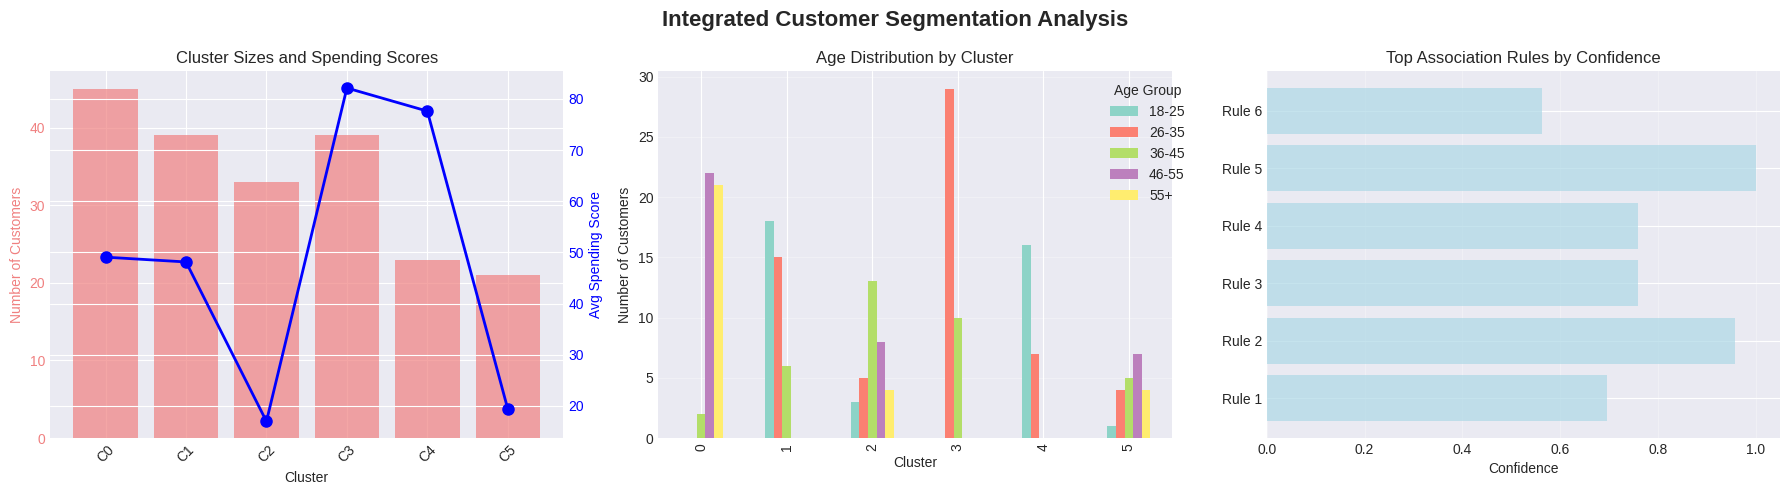

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Cluster sizes and spending
cluster_summary = df.groupby('KMeans_Cluster').agg({
    'CustomerID': 'count',
    'Spending Score (1-100)': 'mean'
}).reset_index()
cluster_summary['Cluster_Name'] = [cluster_names[int(i)]['name'] for i in cluster_summary['KMeans_Cluster']]

x_pos = range(len(cluster_summary))
bars = axes[0].bar(x_pos, cluster_summary['CustomerID'], color='lightcoral', alpha=0.7)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Number of Customers', color='lightcoral')
axes[0].tick_params(axis='y', labelcolor='lightcoral')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f"C{row['KMeans_Cluster']}" for _, row in cluster_summary.iterrows()], rotation=45)
axes[0].set_title('Cluster Sizes and Spending Scores')

ax0_twin = axes[0].twinx()
ax0_twin.plot(x_pos, cluster_summary['Spending Score (1-100)'], 'bo-', linewidth=2, markersize=8)
ax0_twin.set_ylabel('Avg Spending Score', color='blue')
ax0_twin.tick_params(axis='y', labelcolor='blue')

# Plot 2: Age distribution by cluster
cluster_demographics = df.groupby(['KMeans_Cluster', 'Age_Group']).size().unstack(fill_value=0)
cluster_demographics.plot(kind='bar', ax=axes[1], colormap='Set3')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('Age Distribution by Cluster')
axes[1].legend(title='Age Group', bbox_to_anchor=(1.05, 1))
axes[1].grid(alpha=0.3, axis='y')

# Plot 3: Top association rules
if len(strong_rules_df) > 0:
    top_rules_viz = strong_rules_df.head(6)
    y_pos = range(len(top_rules_viz))
    axes[2].barh(y_pos, top_rules_viz['confidence'], color='lightblue', alpha=0.7)
    axes[2].set_yticks(y_pos)
    axes[2].set_yticklabels([f"Rule {i+1}" for i in y_pos])
    axes[2].set_xlabel('Confidence')
    axes[2].set_title('Top Association Rules by Confidence')
    axes[2].grid(axis='x', alpha=0.3)

plt.suptitle('Integrated Customer Segmentation Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('08_integrated_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Business Insights
print("\n BUSINESS INSIGHTS:SEGMENT-SPECIFIC RECOMMENDATIONS")
print("=" * 50)

for cluster_id, info in cluster_names.items():
    print(f"\n  {info['name']} (Cluster {cluster_id}):")
    print(f"    • Profile: {info['dominant_gender']}, avg age {info['avg_age']:.1f}, income ${info['avg_income']:.1f}k")
    print(f"    • Spending: {info['avg_spending']:.1f}/100")

    if info['name'] == "High Rollers":
        print("    •  Strategy: Premium loyalty, exclusive events, luxury brands")
    elif "Young" in info['name']:
        print("    • Strategy: Social media, trendy products, student offers")
    elif "Wealthy" in info['name']:
        print("    • Strategy: Quality focus, personalized service, investment pieces")
    elif "Budget" in info['name']:
        print("    • Strategy: Value bundles, sales promotions, affordable options")
    elif "Senior" in info['name']:
        print("    • Strategy: Comfort products, senior discounts, easy navigation")
    else:
        print("    • Strategy: Balanced approach, seasonal promotions, quality-value mix")




 BUSINESS INSIGHTS:SEGMENT-SPECIFIC RECOMMENDATIONS

  Senior Shoppers (Cluster 0):
    • Profile: Female, avg age 56.3, income $54.3k
    • Spending: 49.1/100
    • Strategy: Comfort products, senior discounts, easy navigation

  Middle Class Moderates (Cluster 1):
    • Profile: Female, avg age 26.8, income $57.1k
    • Spending: 48.1/100
    • Strategy: Balanced approach, seasonal promotions, quality-value mix

  Wealthy Conservatives (Cluster 2):
    • Profile: Male, avg age 41.9, income $88.9k
    • Spending: 17.0/100
    • Strategy: Quality focus, personalized service, investment pieces

  High Rollers (Cluster 3):
    • Profile: Female, avg age 32.7, income $86.5k
    • Spending: 82.1/100
    •  Strategy: Premium loyalty, exclusive events, luxury brands

  Young Spenders (Cluster 4):
    • Profile: Female, avg age 25.0, income $25.3k
    • Spending: 77.6/100
    • Strategy: Social media, trendy products, student offers

  Budget Shoppers (Cluster 5):
    • Profile: Female, avg 


Reflection Questions

    What key behavioral or demographic differences stand out across the clusters?

    How can marketing strategies be tailored to meet the unique preferences of each cluster?

    Are there any risks of stereotyping or bias in how these clusters are interpreted?

    How would you test whether marketing interventions for one cluster are more effective than others?
